# Chapter 5 : Pretraining on Unlabeled Data

In the context of LLMs and other deep learning models, weights refer to the
 trainable parameters that the learning process adjusts. These weights are also
 known as weight parameters or simply parameters. In frameworks like
 PyTorch, these weights are stored in linear layers.
 
 After initializing a layer (new_layer =
 torch.nn.Linear(...)), we can access its weights through the .weight
 attribute, new_layer.weight. 
 
 Additionally, for convenience, PyTorch allows
 direct access to all a model's trainable parameters, including weights and
 biases, through the method model.parameters().

## 5.1 Evaluating generative text models

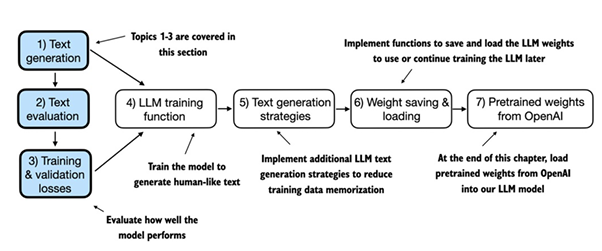

### 5.1.1 Using GPT to generate text

We set up the LLM and briefly recap the text generation
 process.

In [1]:
import torch
from previous_chapters import GPTModel
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

We use dropout of 0.1 above, but it's relatively common to train LLMs without dropout nowadays.

Modern LLMs also don't use bias vectors in the nn.Linear layers for the query, key, and value matrices (unlike earlier GPT models), which is achieved by setting "qkv_bias": False.

We reduce the context length (context_length) of only 256 tokens to reduce the computational resource requirements for training the model, whereas the original 124 million parameter GPT-2 model used 1024 tokens.

Next, we use the generate_text_simple function from the previous chapter to generate text.

In addition, we define two convenience functions, text_to_token_ids and token_ids_to_text, for converting between token and text representations.

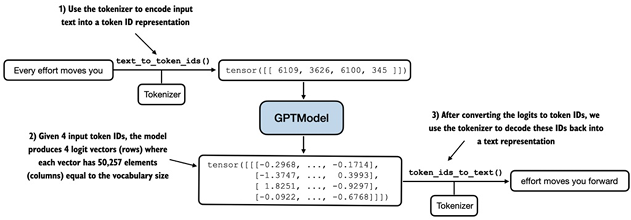

Next, we will implement the text generation process:

In [2]:
import tiktoken
from previous_chapters import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


Based on the output, it's clear the model isn't yet producing coherent text
 because it hasn't undergone training. 
 
 To define what makes text "coherent" or
 "high quality," we have to implement a numerical method to evaluate the
 generated content.

###  5.1.2 Calculating the text generation loss: cross-entropy and perplexity

Suppose we have an inputs tensor containing the token IDs for 2 training examples (rows).

Corresponding to the inputs, the targets contain the desired token IDs that we want the model to generate.

In [3]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

Feeding the inputs to the model, we obtain the logits vector for the 2 input examples that consist of 3 tokens each.

Each of the tokens is a 50,257-dimensional vector corresponding to the size of the vocabulary.

Applying the softmax function, we can turn the logits tensor into a tensor of the same dimension containing probability scores.

In [4]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


We can apply the argmax function to convert the probability scores into predicted token IDs.

The softmax function above produced a 50,257-dimensional vector for each token; the argmax function returns the position of the highest probability score in this vector, which is the predicted token ID for the given token.

Since we have 2 input batches with 3 tokens each, we obtain 2 by 3 predicted token IDs:

In [5]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


If we decode these tokens, we find that these are quite different from the tokens we want the model to predict, namely the target tokens:

In [6]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


The model training aims to increase the softmax probability in the index
 positions corresponding to the correct target token IDs.

 This softmax probability is also used in the evaluation metric: the higher the probability in the correct positions,
 the better.

For each of the two input texts, we can print the initial softmax probability
 scores corresponding to the target tokens:

In [7]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


 The goal of training an LLM is to maximize these values, aiming to get them
 as close to a probability of 1.

We update the model weights so that the
 model outputs higher values for the respective token IDs we want to generate.
 The weight update is done via a process called backpropagation.

Backpropagation requires a loss function, which calculates the difference
 between the model's predicted output and the actual desired output. This loss function
 measures how far off the model's predictions are from the target values.

In mathematical optimization, it is easier to maximize the logarithm of the probability score than the probability score itself.

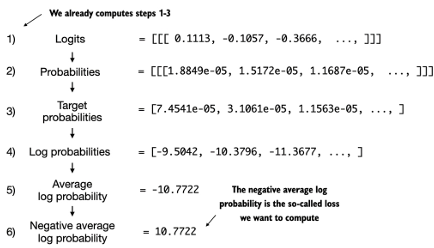

Applying
 the logarithm to the probability scores:

In [8]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


Next, we compute the average log probability:

In [9]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


In deep learning, instead of maximizing the average log-probability, it's a standard convention to minimize the negative average log-probability value.

In our case, instead of maximizing -10.7722 so that it approaches 0, in deep learning, we would minimize 10.7722 so that it approaches 0
The value negative of -10.7722, i.e., 10.7722, is also called cross-entropy loss in deep learning.

In [10]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


PyTorch already implements a cross_entropy function.

 Let's check the shape of
 the logits and target tensors:

In [11]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


For the cross_entropy function in PyTorch, we want to flatten these tensors by combining them over the batch dimension:

In [12]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


Note that the targets are the token IDs, which also represent the index positions in the logits tensors that we want to maximize.

The cross_entropy function in PyTorch will automatically take care of applying the softmax and log-probability computation internally over those token indices in the logits that are to be maximized.

In [13]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


The perplexity is simply the exponential of the cross-entropy loss

The perplexity is often considered more interpretable because it can be understood as the effective vocabulary size that the model is uncertain about at each step.

In other words, perplexity provides a measure of how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset.

Similar to the loss, a lower perplexity indicates that the model predictions are closer to the actual distribution.

In [14]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


### 5.1.3 Calculating the training and validation set losses

In [15]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

 A quick check that the text loaded ok by printing the first and last 99 characters:

In [16]:
# First 99 characters
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [17]:
# Last 99 characters
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


After loading the dataset, we can check the number of characters and tokens
 in the dataset:

In [18]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


Next, we divide the dataset into a training and a validation set and use the data loaders from chapter 2 to prepare the batches for LLM training.

For visualization purposes, the figure below assumes a max_length=6, but for the training loader, we set the max_length equal to the context length that the LLM supports.

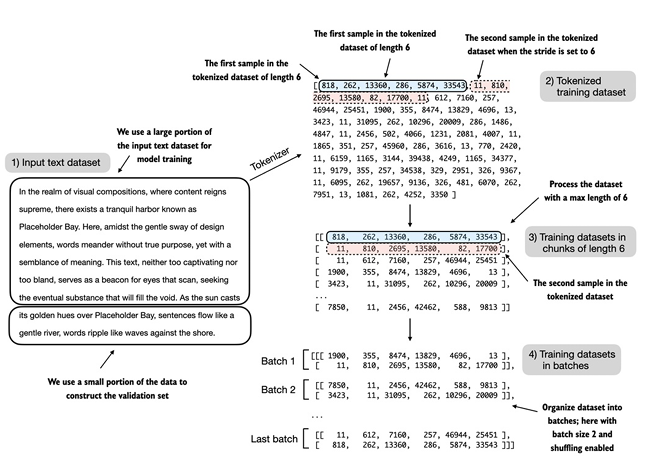

We are training the model with training data presented in similarly-sized
 chunks for simplicity and efficiency. However, in practice, it can also be
 beneficial to train an LLM with variable-length inputs to help the LLM to
 better generalize across different types of inputs when it is being used.

We first
 define a train_ratio to use 90% of the data for training and the remaining
 10% as validation data for model evaluation during training:

In [19]:
from previous_chapters import create_dataloader_v1

# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [20]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

A check to ensure that the data was loaded correctly:

In [21]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


Next, we implement a utility function to calculate the cross-entropy loss of a given batch.

In addition, we implement a second utility function to compute the loss for a user-specified number of batches in a data loader.

In [22]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

By default, the calc_loss_batch function iterates over all batches in a given
 data loader, accumulates the loss in the total_loss variable, and then
 computes and averages the loss over the total number of batches.

 Alternatively, we can specify a smaller number of batches via num_batches
 to speed up the evaluation during model training.

Via the device setting, we ensure that the data is loaded onto the same device as the LLM model.

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98758347829183
Validation loss: 10.981106758117676


## 5.2 Training an LLM

 A typical training loop consists of
 several steps, iterating over the batches in the training set for several epochs. 
 
 In each loop, we
 calculate the loss for each training set batch to determine loss gradients, which we use to update
the model weights so that the training set loss is minimized.

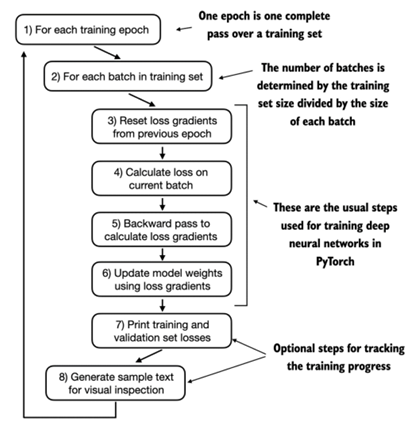

In [25]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

The evaluate_model function prints
 the training and validation set losses after each model update so we can
 evaluate whether the training improves the model.

 More specifically, the evaluate_model function calculates the loss over the
 training and validation set while ensuring the model is in evaluation mode
 with gradient tracking and dropout disabled when calculating the loss over
 the training and validation sets.

The generate_and_print_sample function is a
 convenience function that we use to track whether the model improves during
the training. 

In particular, the generate_and_print_sample function takes a
 text snippet (start_context) as input, converts it into token IDs, and feeds it
 to the LLM to generate a text sample using the generate_text_simple
 function.

Adam optimizers are a popular choice for training deep neural networks.
 However, in our training loop, we opt for the AdamW optimizer. 
 
 AdamW is a
 variant of Adam that improves the weight decay approach, which aims to
 minimize model complexity and prevent overfitting by penalizing larger
 weights. 
 
 This adjustment allows AdamW to achieve more effective
 regularization and better generalization and is thus frequently used in the
 training of LLMs.

Now, let's train the LLM using the training function defined above:

In [26]:
# Note:
# Uncomment the following code to calculate the execution time
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.783, Val loss 9.927
Ep 1 (Step 000005): Train loss 7.985, Val loss 8.335
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.753, Val loss 7.048
Ep 2 (Step 000015): Train loss 6.114, Val loss 6.573
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,,,,, and,,,, and,, and,,,,, and,,,,,,
Ep 3 (Step 000020): Train loss 5.525, Val loss 6.490
Ep 3 (Step 000025): Train loss 5.324, Val loss 6.387
Every effort moves you, and to the picture.                      "I, and the of the of the's the honour, and, and I had been, and I
Ep 4 (Step 000030): Train loss 4.761, Val loss 6.360
Ep 4 (Step 000035): Train loss 4.461, Val loss 6.258
Every effort moves you of the to the picture--as of the picture--as I had been " it was his " I was the     "I was his I had been the his pictures--and it the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 3.833, Val loss 6.196
Every effort moves yo

Let's create a simple plot
 that shows the training and validation set losses side by side:

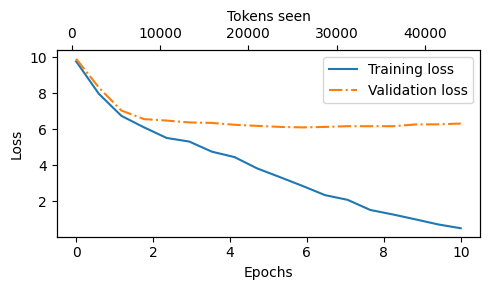

In [27]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

Both the training and validation losses start to improve
 for the first epoch. However, the losses start to diverge past the second epoch.

 This divergence and the fact that the validation loss is much larger than the
 training loss indicate that the model is overfitting to the training data. 
 
 We can
 confirm that the model memorizes the training data verbatim by searching for
 the generated text snippets.

 This memorization is expected since we are working with a very, very small
 training dataset and training the model for multiple epochs.

## 5.3 Decoding strategies to control randomness

Inference is relatively cheap with a relatively small LLM as the GPT model we trained above, so there's no need to use a GPU for it.

In [29]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




The generated token is selected at each
 generation step corresponding to the largest probability score among all
 tokens in the vocabulary.

 This means that the LLM will always generate the same outputs even if we
 run the generate_text_simple function above multiple times on the same
 start context.

We now introduce two concepts, so-called decoding strategies, to modify the generate_text_simple: temperature scaling and top-k sampling.

These will allow the model to control the randomness and diversity of the generated text.

### 5.3.1 Temperature scaling

Temperature scaling is a technique that adds a
 probabilistic selection process to the next-token generation task.

To add variety, we can sample the next token using The torch.multinomial(probs, num_samples=1), sampling from a probability distribution.

Here, each index's chance of being picked corresponds to its probability in the input tensor.

In [33]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

forward


We can now replace the
argmax with the multinomial function in PyTorch:

In [34]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


let's see what happens when we sample the next token 1,000 times using the original softmax probabilities:

In [35]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


We can control the distribution and selection process via a concept called temperature scaling.

"Temperature scaling" is just a fancy word for dividing the logits by a number greater than 0.

Temperatures greater than 1 will result in more uniformly distributed token probabilities after applying the softmax.

Temperatures smaller than 1 will result in more confident (sharper or more peaky) distributions after applying the softmax.

In [36]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

Let's plot the
 original probabilities alongside probabilities scaled with different temperature
 values:

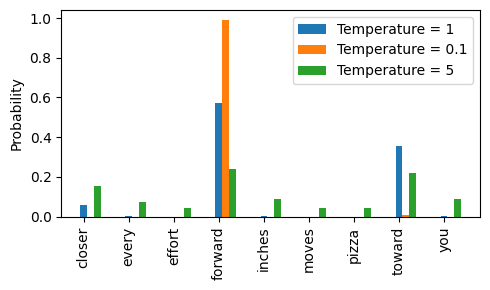

In [37]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

A temperature of 1 divides the logits by 1 before passing them to the softmax
 function to compute the probability scores. In other words, using a
 temperature of 1 is the same as not using any temperature scaling. In this
 case, the tokens are selected with a probability equal to the original softmax
 probability scores via the multinomial sampling function in PyTorch.

Applying very small temperatures, such as
 0.1, will result in sharper distributions such that the behavior of the
 multinomial function selects the most likely token (here: "forward") almost
 100% of the time, approaching the behavior of the argmax function. 
 
 Vice
 versa, a temperature of 5 results in a more uniform distribution where other
 tokens are selected more often. This can add more variety to the generated
 texts but also more often results in nonsensical text. For example, using the
 temperature of 5 results in texts such as "every effort moves you pizza"
 about 4% of the time.

### 5.3.2 Top-k sampling

We implemented a probabilistic sampling approach
 coupled with temperature scaling to increase the diversity of the outputs. 
 
 We
 saw that higher temperature values result in more uniformly distributed next
token probabilities, which result in more diverse outputs as it reduces the
 likelihood of the model repeatedly selecting the most probable token. 
 
 This
 method allows for exploring less likely but potentially more interesting and
 creative paths in the generation process. 
 
 However, One downside of this
approach is that it sometimes leads to grammatically incorrect or completely
 nonsensical outputs

 In top-k sampling, we can restrict the sampled tokens to the top-k most likely
 tokens and exclude all other tokens from the selection process by masking
 their probability scores.

Code Implementation:

In [38]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


Subsequently, we apply PyTorch's where function to set the logit values of
 tokens that are below the lowest logit value within our top-3 selection to
 negative infinity (-inf).

In [39]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")), 
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


 Lastly, let's apply the softmax function to turn these into next-token
 probabilities:

In [40]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


We can now apply the temperature scaling and multinomial function for
 probabilistic sampling introduced to select the next
 token among these 3 non-zero probability scores to generate the next token.

### 5.3.3 Modifying the text generation function

Let's use these two concepts to modify the generate_simple function we used to generate text via the LLM earlier, creating a new generate function:

In [41]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [42]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to my surprise, a little it was the
"Ah enough


## 5.4 Loading and saving model weights in PyTorch

After training and inspecting the model, it is often helpful to save the model so that
 we can use or continue training it later.

Fortunately, saving a PyTorch model is relatively straightforward. The
 recommended way is to save a model's so-called state_dict, a dictionary
 mapping each layer to its parameters, using the torch.save function as
 follows:

In [47]:
torch.save(model.state_dict(), "model.pth")

In the preceding code, "model.pth" is the filename where the state_dict is
 saved. The .pth extension is a convention for PyTorch files, though we could
 technically use any file extension.
 
 Then, after saving the model weights via the state_dict, we can load the
 model weights into a new GPTModel model instance as follows:

In [48]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval();

Adaptive optimizers such as AdamW store additional parameters for each
 model weight. 
 
 AdamW uses historical data to adjust learning rates for each
 model parameter dynamically. 
 
 Without it, the optimizer resets, and the model
 may learn suboptimally or even fail to converge properly, which means that it
 will lose the ability to generate coherent text.
 
 Using torch.save, we can
 save both the model and optimizer state_dict contents as follows:

In [49]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)

Then, we can restore the model and optimizer states as follows by first
 loading the saved data via torch.load and then using the load_state_dict
 method:

In [50]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

## 5.5 Loading pretrained weights from OpenAI

In [52]:
import urllib.request
url = (
 "https://raw.githubusercontent.com/rasbt/"
 "LLMs-from-scratch/main/ch05/"
 "01_main-chapter-code/gpt_download.py"
 )
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x1e46633bf50>)

In [53]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 38.5kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 764kiB/s] 
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 45.0kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [01:16<00:00, 6.53MiB/s]   
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 1.74MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 410kiB/s]  
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 397kiB/s]  


 let's inspect the
 contents of settings and params:

In [54]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


Both settings and params are Python dictionaries. The settings dictionary
 stores the LLM architecture settings similarly to our manually defined
 GPT_CONFIG_124M settings. 
 
 The params dictionary contains the actual weight
 tensors. 
 
 Note that we only printed the dictionary keys because printing the
 weight contents would take up too much screen space, however, we can
 inspect these weight tensors by printing the whole dictionary via
 print(params) or by selecting individual tensors via the respective
 dictionary keys, for example, the embedding layer weights:

In [55]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [56]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [57]:
NEW_CONFIG.update({"context_length": 1024})

In [58]:
NEW_CONFIG.update({"qkv_bias": True})

In [59]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

By default, the GPTModel instance is initialized with random weights for
 pretraining. The last step to using OpenAI's model weights is to override
 these random weights with the weights we loaded into the params dictionary.
 
 
 For this, we will first define a small assign utility function that checks
 whether two tensors or arrays (left and right) have the same dimensions or
 shape and returns the right tensor as trainable PyTorch parameters:

In [60]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

Next, we define a load_weights_into_gpt function that loads the weights
 from the params dictionary into a GPTModel instance gpt:

In [61]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)
gpt.to(device);

If the model is loaded correctly, we can use it to generate new text using our previous generate function:

In [62]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward an equal share for each vote plus half. Inequality is often not an accurate representation of human worth; to know the
